In [1]:
import os
import random
import shutil
import json
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
original_dataset_path = "/kaggle/input/food-101/food-101/food-101/images"
working_dataset_path = "/kaggle/working/food20"
os.makedirs(working_dataset_path, exist_ok=True)

In [3]:
# all_classes = os.listdir(original_dataset_path)
# for classes in all_classes:
#     print(classes)

In [4]:
selected_classes = ['bibimbap', 'grilled_cheese_sandwich', 'spring_rolls', 'hamburger', 'steak', 'sushi', 'pizza', 'fried_rice', 'pad_thai', 'pancakes']
print(len(selected_classes))

10


In [5]:
for classes in selected_classes:
    src = os.path.join(original_dataset_path, classes)
    dest = os.path.join(working_dataset_path, classes)
    shutil.copytree(src, dest)

In [6]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

code for Train/Validation split is referenced from https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator (exChx, 2018)

In [7]:
cnn_train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [8]:
cnn_val_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)

In [9]:
cnn_train_generator = cnn_train_datagen.flow_from_directory(
    working_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 8000 images belonging to 10 classes.


In [10]:
cnn_val_generator = cnn_val_datagen.flow_from_directory(
    working_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2000 images belonging to 10 classes.


In [11]:
with open("class_indices.json", "w") as f:
    json.dump(cnn_train_generator.class_indices, f)

In [12]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(cnn_train_generator.num_classes, activation='softmax')
])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
cnn_model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,247,242 (84.87 MB)

 Trainable params: 22,247,242 (84.87 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,             
    restore_best_weights=True,
    verbose=1
)

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1)

In [15]:
history_cnn = cnn_model.fit(
    cnn_train_generator,
    epochs=epochs,
    validation_data=cnn_val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.1271 - loss: 2.5240 - val_accuracy: 0.2125 - val_loss: 2.1753 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.2334 - loss: 2.1568 - val_accuracy: 0.2570 - val_loss: 2.1325 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.2519 - loss: 2.1222 - val_accuracy: 0.2735 - val_loss: 2.1091 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.2828 - loss: 2.0654 - val_accuracy: 0.2595 - val_loss: 2.1576 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 0.3155 - loss: 2.0127 - val_accuracy: 0.3455 - val_loss: 1.9839 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.3226 - loss: 1.9810 - val_accuracy: 0.3965 - val_loss: 1.8606 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.3533 - loss: 1.9352 - val_

In [16]:
val_loss, val_acc = cnn_model.evaluate(cnn_val_generator)
print(f"\n Validation Accuracy: {val_acc * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 573ms/step - accuracy: 0.4521 - loss: 1.7455

 Validation Accuracy: 45.15%


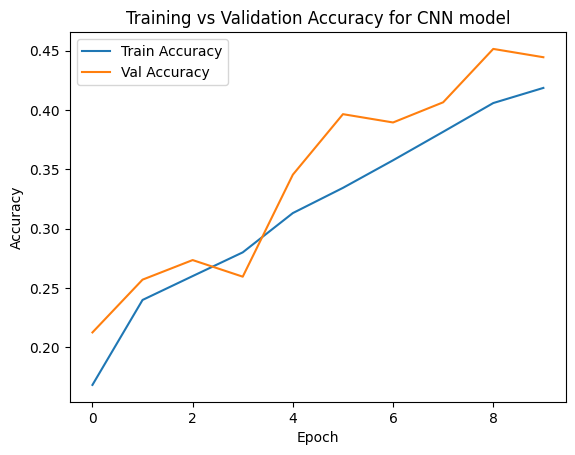

In [17]:
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy for CNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

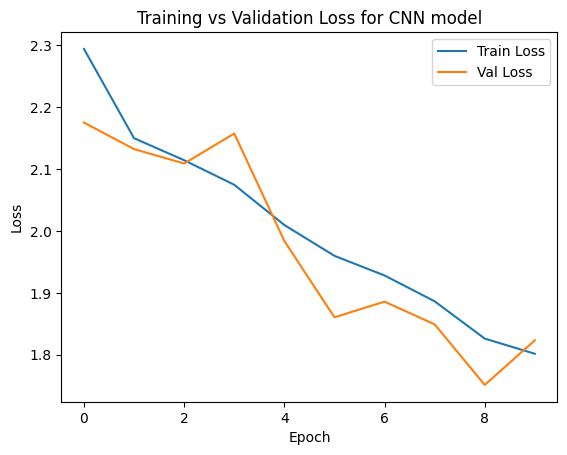

In [18]:
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss for CNN model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
cnn_model.save("cnn_model.keras")

In [20]:
eff_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [21]:
eff_val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [22]:
eff_train_generator = eff_train_datagen.flow_from_directory(
    working_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 8000 images belonging to 10 classes.


In [23]:
eff_val_generator = eff_val_datagen.flow_from_directory(
    working_dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 2000 images belonging to 10 classes.


In [24]:
base_model = EfficientNetB0(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights=None)
base_model.load_weights('/kaggle/input/eff-net-b0/efficientnetb0_notop.h5')
base_model.trainable = False
print(f"Base model has {len(base_model.weights)} weight tensors")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(eff_train_generator.num_classes, activation='softmax')(x)

eff_model = Model(inputs=base_model.input, outputs=output)

loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
eff_model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
# eff_model.summary()

Base model has 312 weight tensors


In [25]:
history_eff = eff_model.fit(
    eff_train_generator,
    epochs=epochs,
    validation_data=eff_val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 443s 2s/step - accuracy: 0.6148 - loss: 1.4420 - val_accuracy: 0.8420 - val_loss: 0.9452 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - accuracy: 0.7839 - loss: 1.0600 - val_accuracy: 0.8555 - val_loss: 0.9040 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 408s 2s/step - accuracy: 0.8159 - loss: 0.9903 - val_accuracy: 0.8645 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.8323 - loss: 0.9613 - val_accuracy: 0.8620 - val_loss: 0.8964 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.8441 - loss: 0.9377 - val_accuracy: 0.8715 - val_loss: 0.8804 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.8520 - loss: 0.9160 - val_accuracy: 0.8790 - val_loss: 0.8652 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 432s 2s/step - accuracy: 0.8594 - loss: 0.

In [26]:
val_loss, val_acc = eff_model.evaluate(eff_val_generator)
print(f"\n Validation Accuracy: {val_acc * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8739 - loss: 0.8738

 Validation Accuracy: 87.90%


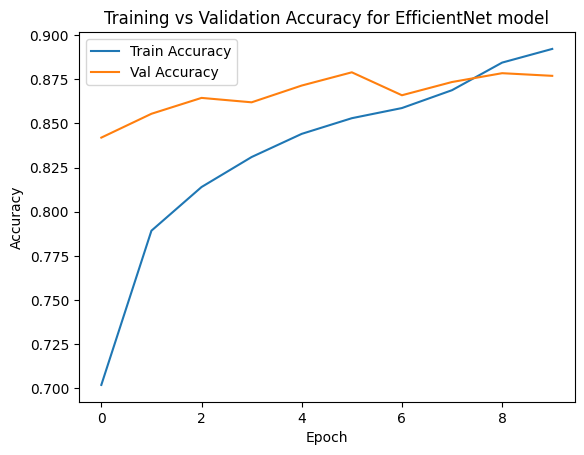

In [27]:
plt.plot(history_eff.history['accuracy'], label='Train Accuracy')
plt.plot(history_eff.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy for EfficientNet model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

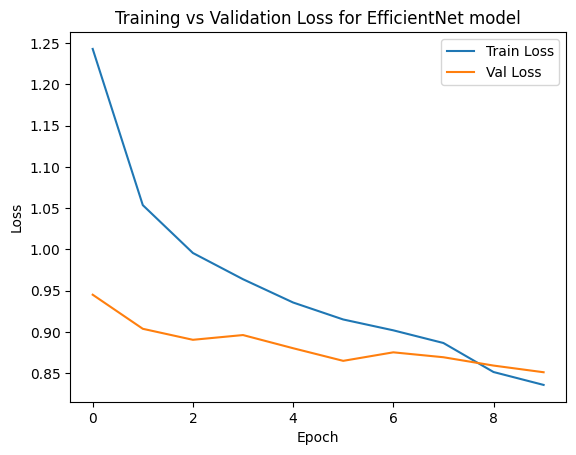

In [28]:
plt.plot(history_eff.history['loss'], label='Train Loss')
plt.plot(history_eff.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss for EfficientNet model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
eff_model.save("eff_model.keras")